# Import Libraries

In [1]:
!pip install tensorflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 67.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attem

In [2]:
# import system libs
import os
import itertools
import PIL
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications.efficientnet import EfficientNetB3
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Read data and store it in dataframe

### Read train data

In [3]:
# Generate train data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folders = os.listdir(train_data_dir)

for fold in folders:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [4]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


### Read test data

In [5]:
# Generate test data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folders = os.listdir(test_data_dir)

for fold in folders:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis=1)

In [6]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


## Split dataframe into valid and test

In [7]:
# split test data into valid & test
valid_df, test_df = train_test_split(ts_df, test_size=.5, shuffle=True, random_state=123)

## Create image data generator

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Show sample from train data

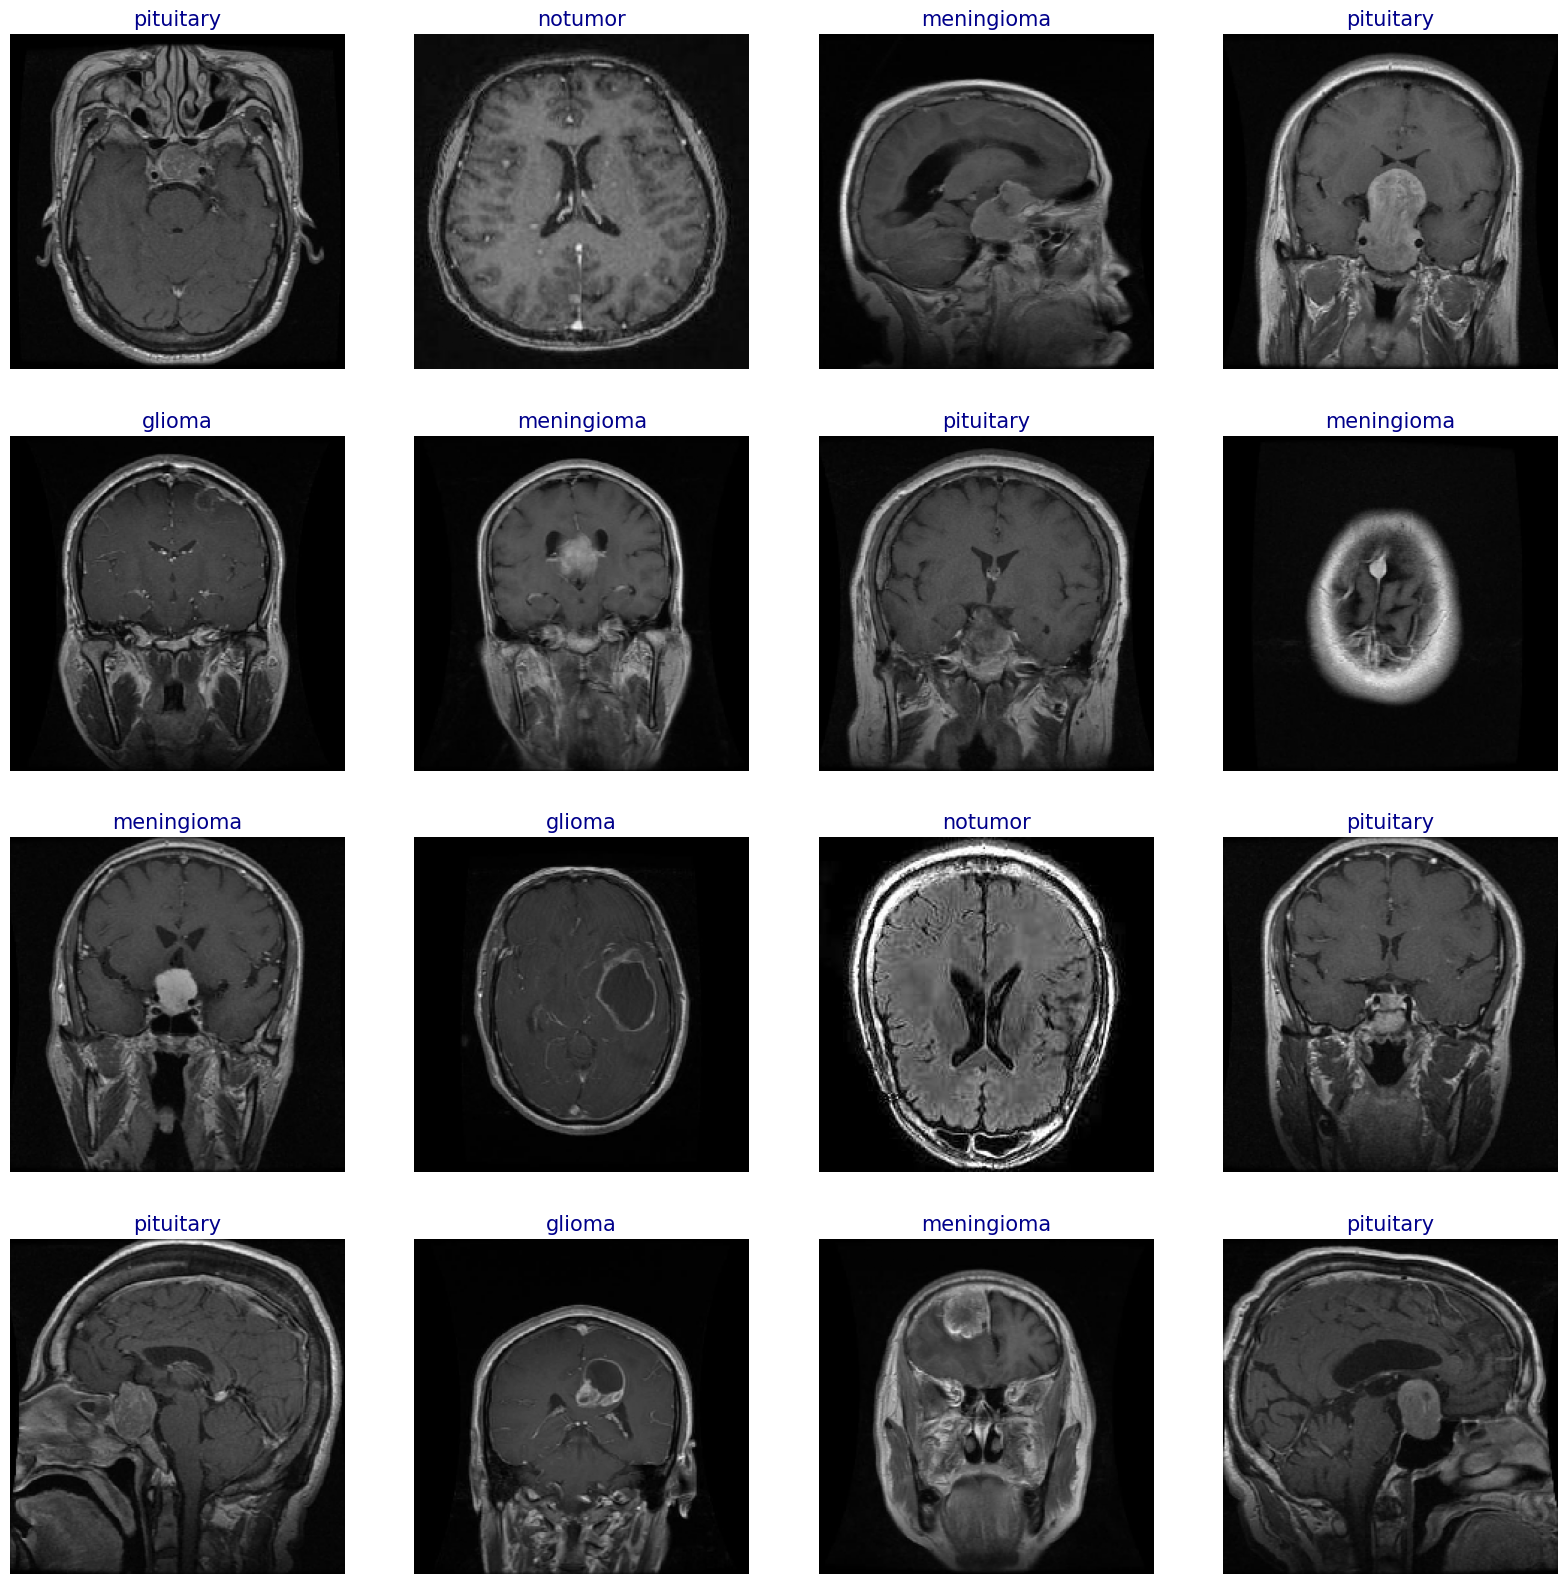

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'darkblue', fontsize= 15)
    plt.axis('off')
plt.show()

# Model Structure

## Generic Model Creation

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = EfficientNetB3(include_top = False, weights = 'imagenet', 
                            input_shape = img_shape, pooling = 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=.99, epsilon=.001),
    Dense(256, activation='relu', kernel_regularizer= regularizers.l2(.016), 
          activity_regularizer=regularizers.l1(.006), bias_regularizer=regularizers.l1(.006)),
    Dropout(rate=.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss = 'categorical_crossentropy', 
              metrics=['acc', tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

43941136/43941136 [==============================] - 1s 0us/step


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_______________________________________

## Train model

In [15]:
history = model.fit(train_gen, epochs=10, validation_data=valid_gen, shuffle=False, verbose=1, validation_steps=None)

Epoch 1/10
357/357 [==============================] - 1650s 5s/step - loss: 5.9926 - acc: 0.8622 - precision: 0.8825 - recall: 0.8377 - auc: 0.9675 - val_loss: 4.0353 - val_acc: 0.9481 - val_precision: 0.9621 - val_recall: 0.9298 - val_auc: 0.9958
Epoch 2/10
357/357 [==============================] - 1654s 5s/step - loss: 2.9665 - acc: 0.9526 - precision: 0.9613 - recall: 0.9386 - auc: 0.9950 - val_loss: 2.0098 - val_acc: 0.9802 - val_precision: 0.9830 - val_recall: 0.9710 - val_auc: 0.9993
Epoch 3/10
357/357 [==============================] - 1625s 5s/step - loss: 1.5179 - acc: 0.9725 - precision: 0.9799 - recall: 0.9624 - auc: 0.9971 - val_loss: 1.0793 - val_acc: 0.9832 - val_precision: 0.9832 - val_recall: 0.9802 - val_auc: 0.9993
Epoch 4/10
357/357 [==============================] - 1631s 5s/step - loss: 0.8157 - acc: 0.9800 - precision: 0.9827 - recall: 0.9741 - auc: 0.9983 - val_loss: 0.7220 - val_acc: 0.9298 - val_precision: 0.9480 - val_recall: 0.9191 - val_auc: 0.9931
Epoch 5/

## Display model performance

In [16]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
tr_perc = history.history['precision']
tr_recall = history.history['recall']
tr_auc = history.history['auc']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
val_perc = history.history['val_precision']
val_recall = history.history['val_recall']
val_auc = history.history['val_auc']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

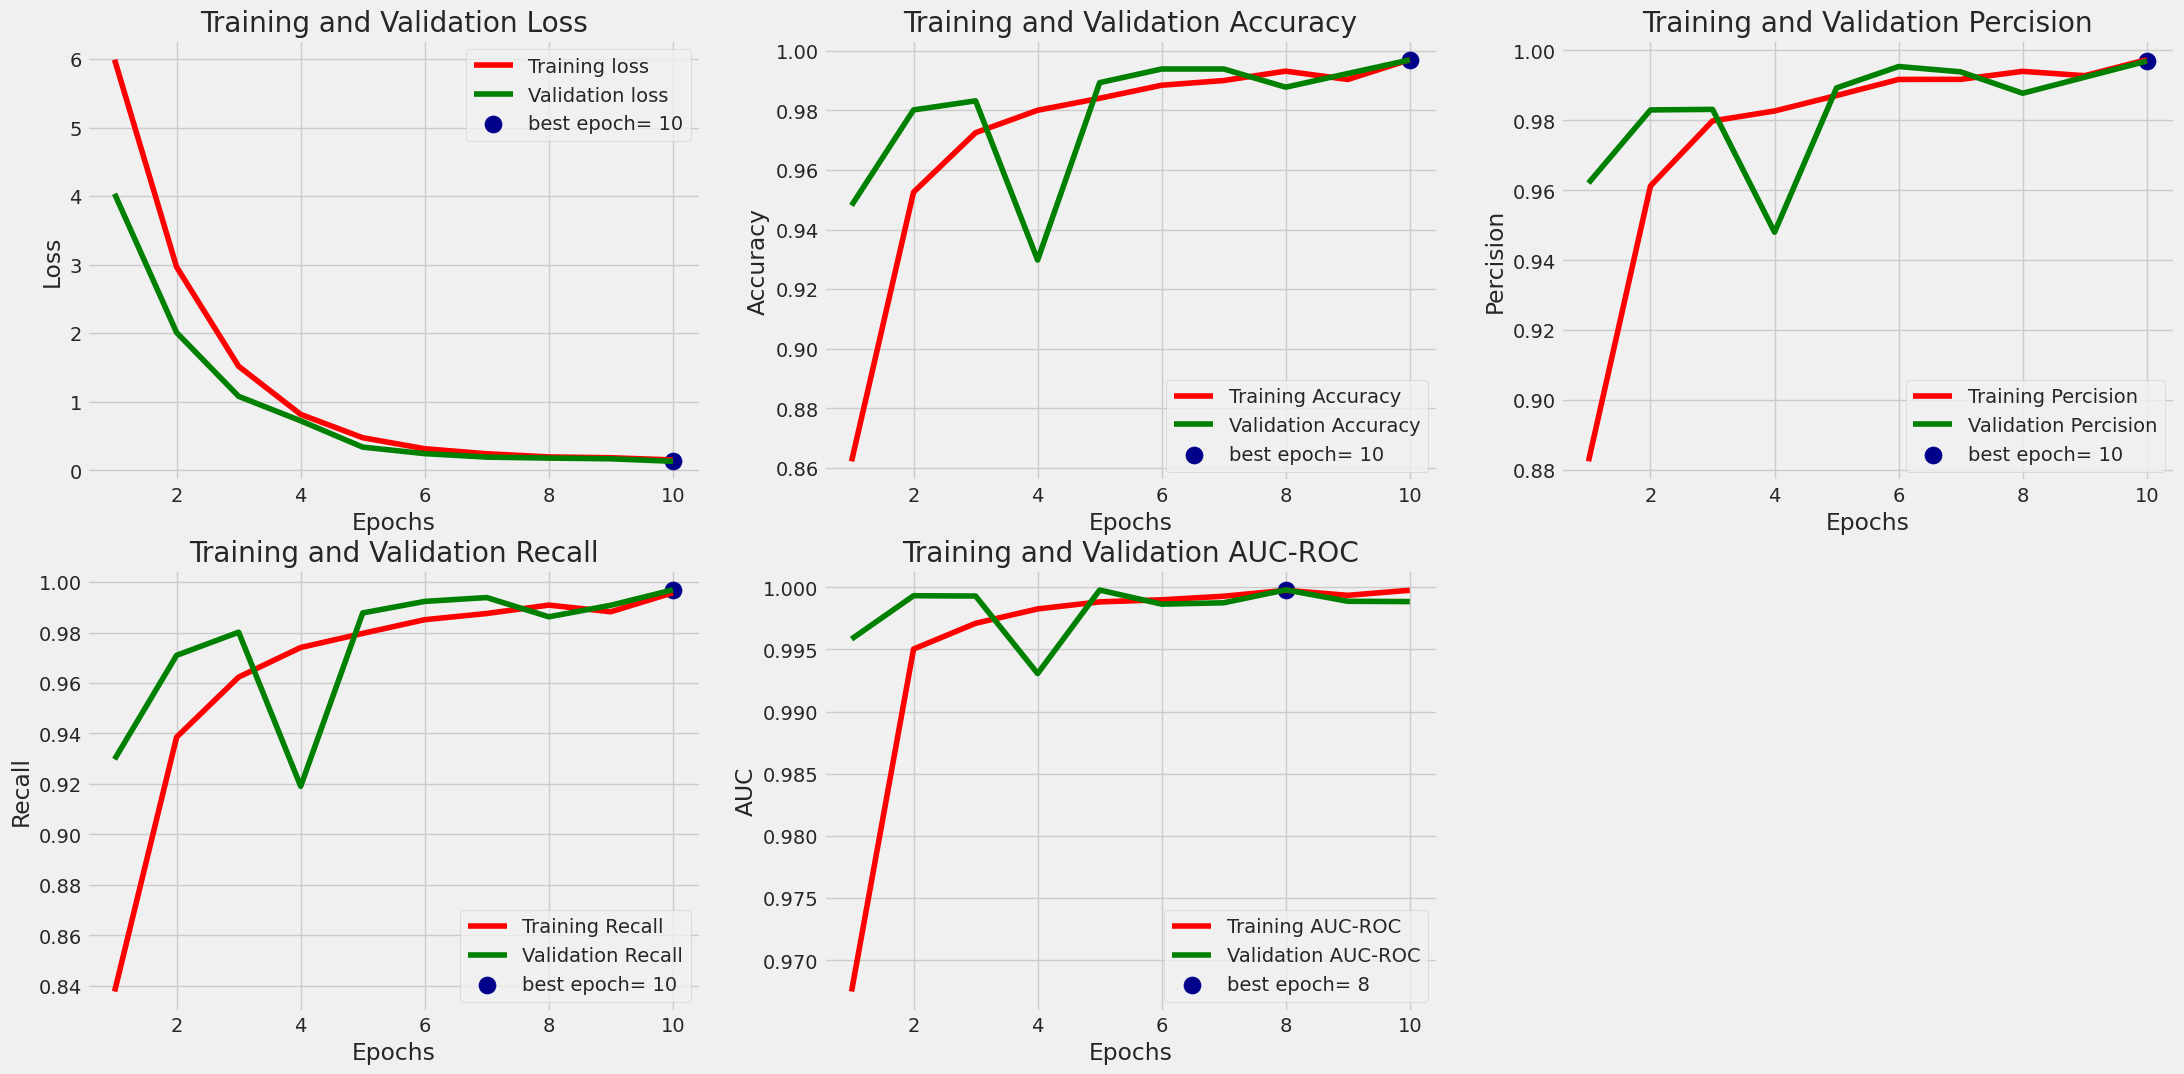

In [19]:
# Plot training history
plt.figure(figsize= (24, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label= 'Training Percision')
plt.plot(Epochs, val_perc, 'g', label= 'Validation Percision')
plt.scatter(index_perc + 1 , perc_highest, s= 150, c= 'darkblue', label= perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label= 'Training Recall')
plt.plot(Epochs, val_recall, 'g', label= 'Validation Recall')
plt.scatter(index_recall + 1 , recall_highest, s= 150, c= 'darkblue', label= recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label= 'Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label= 'Validation AUC-ROC')
plt.scatter(index_auc + 1 , auc_highest, s= 150, c= 'darkblue', label= auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 15s 916ms/step - loss: 0.1506 - acc: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998
Train Loss:  0.1161988228559494
Train Accuracy:  1.0
--------------------
Validation Loss:  0.11561863124370575
Validation Accuracy:  1.0
--------------------
Test Loss:  0.15058651566505432
Test Accuracy:  0.9921875


# Get Predictions

In [22]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 41s 940ms/step


## Confusion Matrics and Classification Report

In [23]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [24]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[146,   3,   0,   0],
       [  2, 141,   0,   0],
       [  0,   0, 200,   0],
       [  0,   1,   0, 163]])

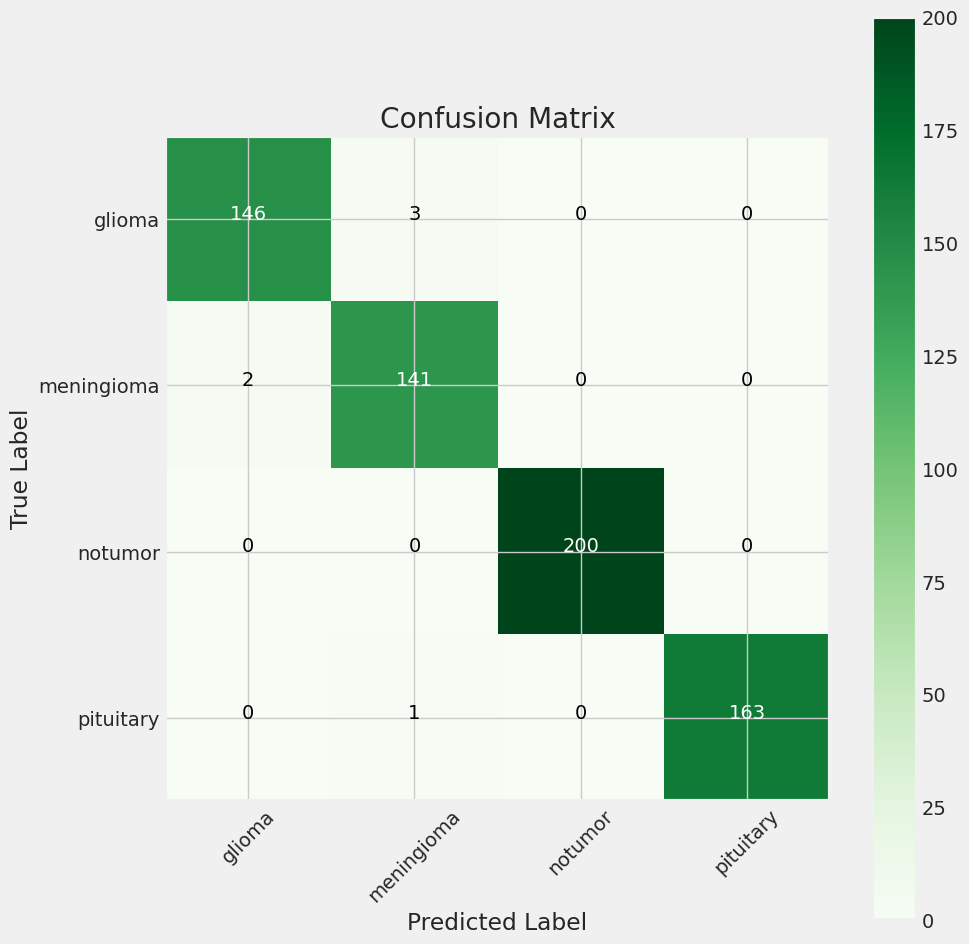

In [25]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [26]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       149
  meningioma       0.97      0.99      0.98       143
     notumor       1.00      1.00      1.00       200
   pituitary       1.00      0.99      1.00       164

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



## Save model

In [27]:
#Save the model
model.save('Brain Tumors.h5')

## Prediction using loaded_model

In [29]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Brain Tumors.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [30]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0007.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
Meningioma
